### DEBUG - TST2207

In [24]:
# Utils
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
uap_path = "./perturbations/uap_vgg16.npy"
dataset_dir = './dataset/train/'

In [3]:
def process_image(img, transpose=False, numpy=False):
    """
    Preprocess the images to displays them in a plot.

    Parameters:
    - img: The image to preprocess.
    - transpose: Bool value if the img needs to be transposed.
    - numpy: Flag to identify if the image is already in a numpy array.

    Returns:
    - img: The image preprocessed.       
    """        
    if transpose:
        if numpy is False:
            img = img.numpy()
        img = img.transpose((1, 2, 0)) # Transform (X, Y, Z) shape
    img = (img - img.min()) / (img.max() - img.min()) # Clip the image to [0, 255] values
    return img


In [4]:
def obj_variance(obj, type=None):
    """
    Display the maximum and minimum value in a given object.

    Parameters:
    - obj: A given object.
    - type: Object type. Can be "tensor" and "numpy".
    """

    if type == "tensor":
        tensor_min = torch.min(obj)
        tensor_max = torch.max(obj)
        
        print("Maximum value:", "{:.5f}".format(tensor_max.item()))
        print("Minimum value:", "{:.5f}".format(tensor_min.item()))
    else:
        numpy_min = "{:.5f}".format(np.max(obj))
        numpy_max = "{:.5f}".format(np.min(obj))
        
        print("Maximum value:", numpy_max)
        print("Minimum value:", numpy_min)

In [5]:
def get_min_max(tensor):
    min_val = torch.min(tensor)
    max_val = torch.max(tensor)
    print("Min: " + str(min_val))
    print("Max: " + str(max_val))

In [6]:
def normalize(x):
    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    return (x - mean.type_as(x)[None,:,None,None]) / std.type_as(x)[None,:,None,None]

In [7]:
def get_uap(path, device):
    uap = np.load(path)
    uap = torch.tensor(uap, device=device)
    return uap

In [8]:
### @joseareia -- 2024-07-19
def prepare_model(model_name, device):
    model = getattr(models, model_name)(pretrained=True).to(device)
    return model

In [34]:
### @joseareia -- 2024-07-23
def get_dataloader(dataset, batch_size, num_images, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
    
    val_dataset =  datasets.ImageFolder(dataset, transform=transform)
    
    num_classes = len(val_dataset.classes)
    
    class_indices = {i: [] for i in range(num_classes)}
    for idx, (_, label) in enumerate(val_dataset.samples):
        class_indices[label].append(idx)
        
    samples_per_class = num_images // num_classes
    
    subset_indices = []
    for i in range(num_classes):
        class_subset_indices = np.random.choice(class_indices[i], samples_per_class, replace=False).tolist()
        subset_indices.extend(class_subset_indices)
        
    val_subset = Subset(val_dataset, subset_indices)
    
    dataloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    
    return dataloader

In [35]:
def get_fooling_rate(model, delta, dataloader):
    real_adv_images = []

    model.eval()    
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(normalize(images))
            _, predicted = torch.max(outputs.data, 1)

            adv_images = torch.add(delta, images).clamp(0, 1)
            adv_outputs = model(normalize(adv_images))

            _, adv_predicted = torch.max(adv_outputs.data, 1)

            ### Beginning of changes by @joseareia -- 2024-07-22
                
            misclassified_indices = (predicted != adv_predicted).nonzero(as_tuple=True)[0]
            if misclassified_indices.numel() > 0:
                real_adv_images.append(adv_images[misclassified_indices].cpu())
                
            del images, labels, outputs, adv_images, adv_outputs, predicted, adv_predicted
            torch.cuda.empty_cache()
            
            ### End of changes by @joseareia
    
    return real_adv_images

In [36]:
%%time
uap = get_uap(uap_path, device)

CPU times: user 2.06 ms, sys: 10.7 ms, total: 12.8 ms
Wall time: 11.6 ms


In [37]:
%%time
model = prepare_model('vgg16', device)

CPU times: user 1.04 s, sys: 449 ms, total: 1.49 s
Wall time: 1.09 s


In [39]:
%%time
dataloader = get_dataloader(dataset=dataset_dir, batch_size=4, num_images=1500, shuffle=True)

CPU times: user 221 ms, sys: 104 ms, total: 325 ms
Wall time: 323 ms


In [42]:
%%time
delta = torch.clamp(uap, -10/255, 10/255)
adv_images = get_fooling_rate(model, delta, dataloader)

CPU times: user 27.7 s, sys: 692 ms, total: 28.4 s
Wall time: 28.5 s


In [71]:
total_images = len(adv_images)*4
print("Total images: " + str(total_images))

Total images: 1000


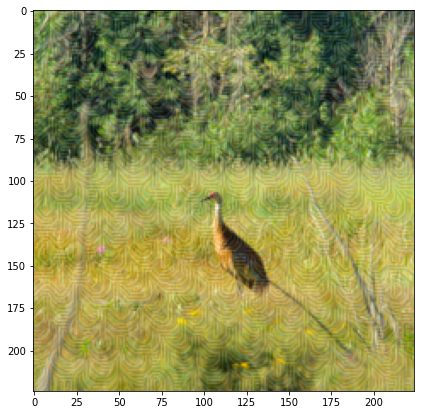

In [76]:
adv_images_processed = process_image(adv_images[0][0].squeeze().cpu(), transpose=True, numpy=False)
plt.figure(figsize = (7,7))
plt.imshow(adv_images_processed)

In [126]:
imgs, labels = next(iter(dataloader))

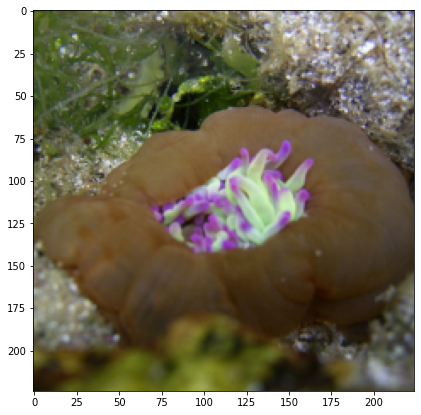

In [127]:
images_processed = process_image(imgs[0].squeeze().cpu(), transpose=True, numpy=False)
plt.figure(figsize = (7,7))
plt.imshow(images_processed)

---

### DEBUG --- RETRIEVE ALL CLASSES

In [15]:
dataset = './dataset/train/'

In [16]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

val_dataset =  datasets.ImageFolder(dataset, transform=transform)

len(val_dataset)

130000

In [17]:
num_classes = len(val_dataset.classes)

In [20]:
num_classes

100

In [18]:
class_indices = {i: [] for i in range(num_classes)}
for idx, (_, label) in enumerate(val_dataset.samples):
    class_indices[label].append(idx)

In [21]:
samples_per_class = 1000 // num_classes

In [22]:
subset_indices = []
for i in range(num_classes):
    class_subset_indices = np.random.choice(class_indices[i], samples_per_class, replace=False).tolist()
    subset_indices.extend(class_subset_indices)

In [25]:
val_subset = Subset(val_dataset, subset_indices)

In [27]:
dataloader = torch.utils.data.DataLoader(val_subset, batch_size=8, shuffle=True, num_workers=2)

In [31]:
len(dataloader)

500

In [32]:
imgs, labels = next(iter(dataloader))

In [33]:
len(imgs)

2